In [ ]:
#cd /content/drive/MyDrive/Colab Notebooks/chess_board_recognizer/chess_board_recognizer/create_model/

# Imports e parâmetros

In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_blobs

import pandas as pd
import numpy as np
import time
import os
from glob import glob
import seaborn as sns


import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
 # Configurando hiperparâmetros.
args = {
    'epoch_num': 50,     
    'lr': 1e-4,         
    'weight_decay': 5e-4,
    'num_workers': 2,     
    'batch_size': 100,
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


# Obtendo e Analisando Dataset

In [3]:
!git clone https://github.com/mtrentz/chess_board_recognizer.git

Cloning into 'chess_board_recognizer'...
remote: Enumerating objects: 9040, done.
remote: Total 9040 (delta 0), reused 0 (delta 0), pack-reused 9040
Receiving objects: 100% (9040/9040), 149.30 MiB | 39.28 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (8987/8987), done.


In [4]:
# Pegando as dimensões de todas as imagens
dim1 = []
dim2 = []
for image_filename in glob(os.path.join('.', 'chess_board_recognizer', 'cell_dataset', '*', '*', '*.png')):
    img = imread(image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


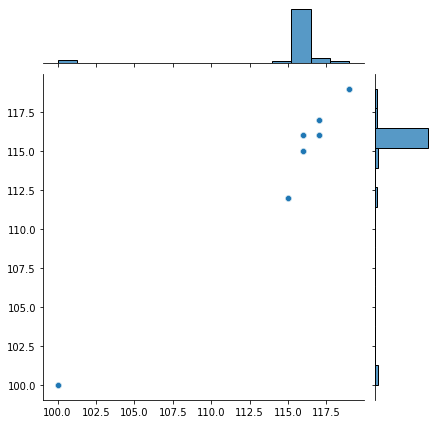

In [5]:
sns.jointplot(dim1,dim2)

In [6]:
df = pd.DataFrame(data={'X':dim1, 'Y':dim2})
df.describe()

,X,Y
count,8400.000000,8400.000000
mean,115.390714,115.214167
std,3.394134,3.418079
min,100.000000,100.000000
25%,116.000000,116.000000
50%,116.000000,116.000000
75%,116.000000,116.000000
max,119.000000,119.000000


In [7]:
del dim1, dim2, df

In [8]:
# Para normalizar, preciso antes carregar todo o dataset e ver os valores dos pixels
data_transform = transforms.Compose([
                                     transforms.Resize((116, 116)),
                                     transforms.ToTensor(),
                                     transforms.Grayscale(),])

train_set_un_norm = datasets.ImageFolder('./chess_board_recognizer/cell_dataset/train',
                                 transform=data_transform)

train_loader_un_norm = DataLoader(train_set_un_norm, batch_size=len(train_set_un_norm), num_workers=1)
train_data_un_norm = next(iter(train_loader_un_norm))

mean = train_data_un_norm[0].mean()
std = train_data_un_norm[0].std()

print(mean, std)

tensor(0.6146) tensor(0.2454)


# Dataset / Dataloader

In [9]:
ls ./chess_board_recognizer/cell_dataset/

test/  train/  validate/


In [10]:
data_transform = transforms.Compose([
                                     transforms.Resize((116, 116)),
                                     transforms.ToTensor(),
                                     transforms.Grayscale(),
                                     # Passa a media/desvio que calculei antes para normalizar
                                     transforms.Normalize(mean, std)])

train_set = datasets.ImageFolder('./chess_board_recognizer/cell_dataset/train',
                                 transform=data_transform)

test_set = datasets.ImageFolder('./chess_board_recognizer/cell_dataset/test',
                                transform=data_transform)

validate_set = datasets.ImageFolder('./chess_board_recognizer/cell_dataset/validate',
                                    transform=data_transform)

In [11]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True)

test_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True)

# Modelo

In [12]:
# Definindo a rede
net = nn.Sequential(
        ## ConvBlock 1
        nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=0),        # entrada: (b, 1, 116, 116) e saida: (b, 1, 114, 114)
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),           # entrada: (b, 6, 114, 114) e saida: (b, 6, 57, 57)
        
        ## ConvBlock 2
        nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=0),       # entrada: (b, 6, 57, 57) e saida: (b, 16, 55, 55)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=1),           # entrada: (b, 16, 55, 55) e saida: (b, 16, 28, 28)
        
        ## ConvBlock 3
        nn.Conv2d(16, 120, kernel_size=7, stride=7, padding=0),     # entrada: (b, 16, 28, 28) e saida: (b, 120, 4, 4)
        nn.BatchNorm2d(120),
        nn.ReLU(),
        nn.Flatten(),  # lineariza formando um vetor                # entrada: (b, 120, 4, 4) e saida: (b, 120*4*4) = (b, 1920)
        
        ## DenseBlock
        nn.Linear(1920, 960),                                         # entrada: (b, 1920) e saida: (b, 960)
        nn.ReLU(),
        nn.Linear(960, 100),                                         # entrada: (b, 960) e saida: (b, 100)
        nn.ReLU(),
        nn.Linear(100, 6),                                          # entrada: (b, 84) e saida: (b, 10)
        )

# Subindo no hardware de GPU (se disponível)
net = net.to(args['device'])

In [13]:
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=1)
  (8): Conv2d(16, 120, kernel_size=(7, 7), stride=(7, 7))
  (9): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=1920, out_features=960, bias=True)
  (13): ReLU()
  (14): Linear(in_features=960, out_features=100, bias=True)
  (15): ReLU()
  (16): Linear(in_features=100, out_features=6, bias=True)
)

In [14]:
# # Definindo a rede
# net = nn.Sequential(
#         ## ConvBlock 1
#         nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),        # entrada: (b, 1, 116, 116) e saida: (b, 1, 116, 116)
#         nn.BatchNorm2d(16),
#         nn.Tanh(),
#         nn.AvgPool2d(kernel_size=2, stride=2, padding=0),           # entrada: (b, 16, 116, 116) e saida: (b, 16, 58, 58)
        
#         ## ConvBlock 2
#         nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),       # entrada: (b, 16, 58, 58) e saida: (b, 32, 58, 58)
#         nn.BatchNorm2d(32),
#         nn.Tanh(),
#         nn.AvgPool2d(kernel_size=5, stride=5, padding=1),           # entrada: (b, 32, 58, 58) e saida: (b, 32, 12, 12)
        
#         ## ConvBlock 3
#         nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),     # entrada: (b, 32, 12, 12) e saida: (b, 32, 12, 12)
#         nn.BatchNorm2d(32),
#         nn.Tanh(),
#         nn.Flatten(),  # lineariza formando um vetor                # entrada: (b, 32, 12, 12) e saida: (b, 120*4*4) = (b, 4608)
        
#         ## DenseBlock
#         nn.Linear(4608, 4096),                                      
#         nn.Tanh(),
#         nn.Linear(4096, 1024),                                      
#         nn.Tanh(),
#         nn.Linear(1024, 128),                                      
#         nn.Tanh(),
#         nn.Linear(128, 6),                     
#         )

# # Subindo no hardware de GPU (se disponível)
# net = net.to(args['device'])
# net

In [15]:
# # Definindo a rede
# net = nn.Sequential(
#         ## ConvBlock 1
#         nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),      # entrada: (b, 3, 116, 116) e saida: (b, 64, 116, 116)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 64, 116, 116) e saida: (b, 64, 58, 58)
        
#         ## ConvBlock
#         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),    # entrada: (b, 64, 58, 58) e saida: (b, 128, 58, 58)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 128, 58, 58) e saida: (b, 128, 29, 29)
        
#         ## ConvBlock 3
#         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),   # entrada: (b, 128, 29, 29) e saida: (b, 256, 29, 29)
#         nn.ReLU(),
#         nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),   # entrada: (b, 256, 29, 29) e saida: (b, 256, 29, 29)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=1),          # entrada: (b, 256, 29, 29) e saida: (b, 256, 15, 15)
        
#         # ## ConvBlock 4
#         # nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 256, 28, 28) e saida: (b, 512, 28, 28)
#         # nn.ReLU(),
#         # nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 512, 28, 28) e saida: (b, 512, 28, 28)
#         # nn.ReLU(),
#         # nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 512, 28, 28) e saida: (b, 512, 14, 14)
        
#         # ## ConvBlock 4
#         nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),   # entrada: (b, 256, 15, 15) e saida: (b, 256, 15, 15)
#         nn.ReLU(),
#         nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),   # entrada: (b, 256, 15, 15) e saida: (b, 256, 15, 15)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=1),          # entrada: (b, 256, 15, 15) e saida: (b, 256, 8, 8)
#         nn.Flatten(),  # lineariza formando um vetor               # entrada: (b, 256, 8, 8) e saida: (b, 256*8*8) = (b, 16384)
 
#         ## DenseBlock
#         nn.Linear(16384, 16384),                                    # entrada: (b, 25088) e saida: (b, 4096)
#         nn.ReLU(),
#         nn.Linear(16384, 8192),                                    # entrada: (b, 25088) e saida: (b, 4096)
#         nn.ReLU(),
#         nn.Linear(8192, 4096),                                    # entrada: (b, 25088) e saida: (b, 4096)
#         nn.ReLU(),
#         nn.Linear(4096, 6),                                       # entrada: (b, 4096) e saida: (b, 10)
#         nn.Softmax(dim=-1)
#         )

# # Subindo no hardware de GPU (se disponível)
# net = net.to(args['device'])

In [16]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Treino / Validação

In [18]:
def train(train_loader, net, epoch):
  global pred_list
  global rotulo_list

  # Training mode
  net.train()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  for batch in train_loader:
    
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    X = dado
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    _, pred = torch.max(ypred, axis=1)
    pred_list.append(pred.cpu().numpy())
    rotulo_list.append(rotulo.cpu().numpy())
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()

In [19]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

      _, pred = torch.max(ypred, axis=1)
      pred_list.append(pred.cpu().numpy())
      rotulo_list.append(rotulo.cpu().numpy())

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()

In [25]:
pred_list[0][0]

3

In [24]:
rotulo_list

[array([3, 3, 1, 0, 3, 3, 5, 4, 0, 1, 0, 0, 0, 3, 5, 3, 5, 2, 5, 3, 5, 5,
        1, 3, 3, 1, 2, 1, 1, 0, 2, 1, 5, 0, 0, 4, 3, 0, 2, 0, 2, 1, 0, 4,
        1, 4, 4, 3, 1, 0, 2, 1, 2, 3, 1, 1, 1, 4, 3, 3, 0, 4, 5, 1, 4, 5,
        5, 4, 4, 5, 5, 1, 2, 3, 2, 4, 3, 4, 3, 4, 2, 5, 5, 0, 1, 0, 4, 0,
        2, 3, 5, 5, 3, 0, 4, 5, 1, 2, 3, 3]),
 array([4, 3, 5, 3, 4, 3, 5, 5, 3, 1, 0, 5, 3, 3, 3, 0, 4, 2, 1, 5, 3, 0,
        1, 1, 2, 5, 3, 5, 5, 5, 5, 2, 3, 5, 2, 1, 4, 3, 4, 3, 2, 3, 0, 1,
        0, 2, 4, 0, 1, 1, 4, 0, 4, 0, 4, 3, 2, 3, 2, 0, 2, 3, 1, 3, 5, 5,
        5, 2, 0, 2, 3, 4, 0, 5, 2, 0, 2, 4, 4, 2, 4, 5, 2, 3, 0, 4, 2, 3,
        5, 0, 4, 5, 2, 0, 1, 3, 3, 3, 2, 1])]

In [21]:
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):
  
  # Train
  train_losses.append(train(train_loader, net, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, net, epoch))

KeyboardInterrupt: ignored

# Losses

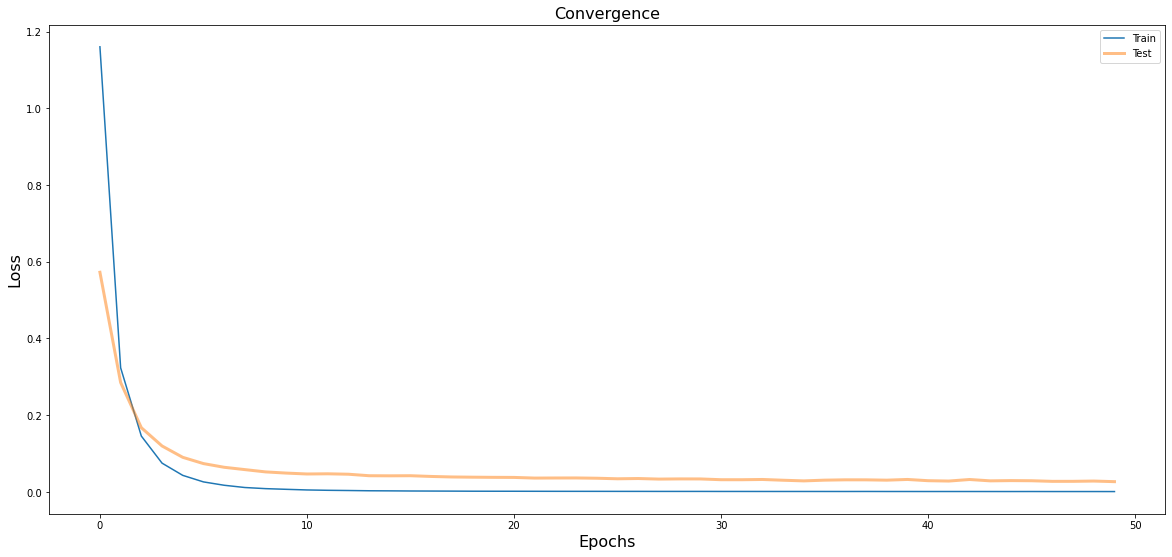

In [ ]:
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()

# Report

In [ ]:
validate_loader = DataLoader(validate_set,
                          # Se não me engano tem 1200 dados no validate
                          batch_size=1000, 
                          shuffle=True)

In [ ]:
for b in validate_loader:
  X_test, Y_test = b
  X_test = X_test.to(args['device'])
  Y_test = Y_test.to(args['device'])
  pred = net(X_test)
  pred = pred.argmax(dim=1).to('cpu').numpy()
  Y_test = Y_test.to('cpu').numpy()
  print(classification_report(Y_test, pred, target_names=list(validate_set.class_to_idx.keys())))
  break

              precision    recall  f1-score   support

      bishop       1.00      1.00      1.00       171
        king       1.00      0.99      1.00       173
      knight       1.00      0.99      1.00       163
        pawn       1.00      1.00      1.00       169
       queen       0.99      1.00      1.00       160
        rook       0.99      1.00      1.00       164

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [ ]:
labels = list(validate_set.class_to_idx.values())
cm = confusion_matrix(Y_test, pred, labels)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

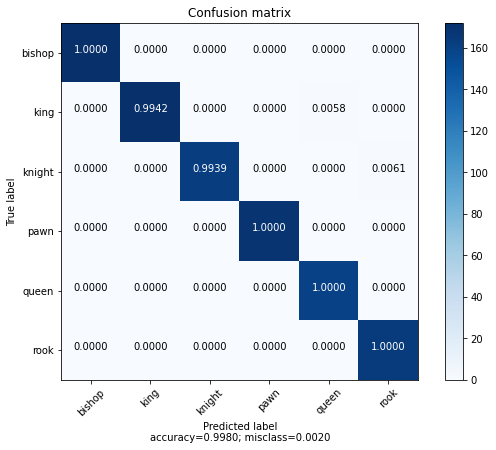

In [ ]:
plot_confusion_matrix(cm,
                      target_names= validate_set.class_to_idx.keys(),
                        title='Confusion matrix',
                        cmap=None,
                        normalize=True)

# Caderno de Modelos

1.

              precision    recall  f1-score   support

      bishop       0.97      0.98      0.97       169
        king       0.99      0.97      0.98       166
      knight       0.98      0.99      0.98       162
        pawn       0.97      1.00      0.98       164
       queen       0.99      0.98      0.98       163
        rook       0.99      0.99      0.99       176

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

```
Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Tanh()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=1)
  (8): Conv2d(16, 120, kernel_size=(7, 7), stride=(7, 7))
  (9): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Tanh()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=1920, out_features=960, bias=True)
  (13): Tanh()
  (14): Linear(in_features=960, out_features=100, bias=True)
  (15): Tanh()
  (16): Linear(in_features=100, out_features=6, bias=True)
)
```


 ```
args = {
    'epoch_num': 100,     
    'lr': 1e-4,         
    'weight_decay': 5e-4,
    'num_workers': 2,     
    'batch_size': 50,
}
```

> Trocando tudo pra ReLU deu 100%

---
2.

Deixando o de antes, com ReLU porém esses parâmetros ficou mt bom
```
 # Configurando hiperparâmetros.
args = {
    'epoch_num': 50,     
    'lr': 1e-4,         
    'weight_decay': 5e-4,
    'num_workers': 2,     
    'batch_size': 100,
}
```
```
              precision    recall  f1-score   support

      bishop       0.99      1.00      1.00       174
        king       1.00      0.99      1.00       168
      knight       1.00      0.99      1.00       170
        pawn       1.00      1.00      1.00       164
       queen       0.99      0.99      0.99       157
        rook       0.99      1.00      1.00       167

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000
```

---
3.
Normalizando esse ultimo modelo ai
```
              precision    recall  f1-score   support

      bishop       1.00      1.00      1.00       171
        king       1.00      0.99      1.00       173
      knight       1.00      0.99      1.00       163
        pawn       1.00      1.00      1.00       169
       queen       0.99      1.00      1.00       160
        rook       0.99      1.00      1.00       164

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000
```

dps dos 2 decimais na real ficou um pouqinho pior... O certo na